# Linking Assets
The LinkedAsset class can link two Assets and wrap them as one asset with additional constraints.

## Example Portfolio
### Imports

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import eaopack as eao
from eaopack.portfolio import Portfolio, LinkedAsset

### Defining a portfolio

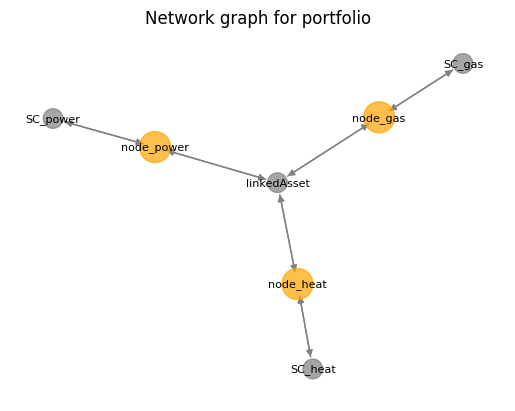

In [2]:
node_power = eao.assets.Node('node_power')
node_heat = eao.assets.Node('node_heat')
node_gas = eao.assets.Node('node_gas')

timegrid = eao.assets.Timegrid(dt.date(2021, 1, 1), dt.date(2021, 1, 2), freq='h', main_time_unit='h')
simple_contract_power = eao.assets.SimpleContract(name='SC_power', price='price_power', nodes=node_power,
                                             min_cap=-100., max_cap=0)
simple_contract_heat = eao.assets.SimpleContract(name='SC_heat', price='price_heat', nodes=node_heat,
                                             min_cap=-100., max_cap=0.)
simple_contract_gas = eao.assets.SimpleContract(name='SC_gas', price='price_gas', nodes=node_gas,
                                             min_cap=0., max_cap=100.)


chpasset1 = eao.assets.CHPAsset(name='CHP1', 
                               nodes=[node_power, node_heat, node_gas],
                               min_cap=5., 
                               max_cap=30.,
                               extra_costs=0,
                               freq='h',
                               conversion_factor_power_heat=0.5, 
                               max_share_heat=0.5,
                               ramp=20, 
                               start_costs=0., 
                               running_costs=0., 
                               min_runtime=0, 
                               time_already_running=0., 
                               last_dispatch=0., 
                               start_fuel=0)
chpasset2 = eao.assets.CHPAsset(name='CHP2', 
                               nodes=[node_power, node_heat, node_gas],
                               min_cap=5., 
                               max_cap=30.,
                               extra_costs=0,
                               freq='h',
                               conversion_factor_power_heat=0.5, 
                               max_share_heat=0.5,
                               ramp=20, 
                               start_costs=0., 
                               running_costs=0., 
                               min_runtime=0, 
                               time_already_running=1., 
                               last_dispatch=0., 
                               start_fuel=0)

prices = {'price_power': np.sin(0.5*np.pi * np.arange(timegrid.T)*np.pi/10)+2,
          'price_heat': np.cos(0.5*np.pi * np.arange(timegrid.T)*np.pi/10)+2, 
          'price_gas': np.ones(timegrid.T)*2, 
          }

linkedAsset_portfolio = Portfolio([chpasset1, chpasset2])
linkedAsset = LinkedAsset(portfolio=linkedAsset_portfolio, asset1_variable=(chpasset1, "bool_on", None), asset2_variable=(chpasset2, "bool_on", None), name="linkedAsset", nodes=[node_power, node_heat, node_gas], time_back=2, time_forward=1)

portfolio = eao.portfolio.Portfolio([linkedAsset, simple_contract_power, simple_contract_heat, simple_contract_gas])
eao.network_graphs.create_graph(portf = portfolio)

### Performing the Optimization

In [3]:
op = portfolio.setup_optim_problem(prices, timegrid)
res = op.optimize(solver="GLPK_MI")
# res = op.optimize(solver="GLPK", make_soft_problem=True)  # Relax bool variables, i.e. allow "half on"
out = eao.io.extract_output(portfolio, op, res, prices)
out['summary']

,Values
Parameter,
status,successful
value,722.195228


### Plotting the Results

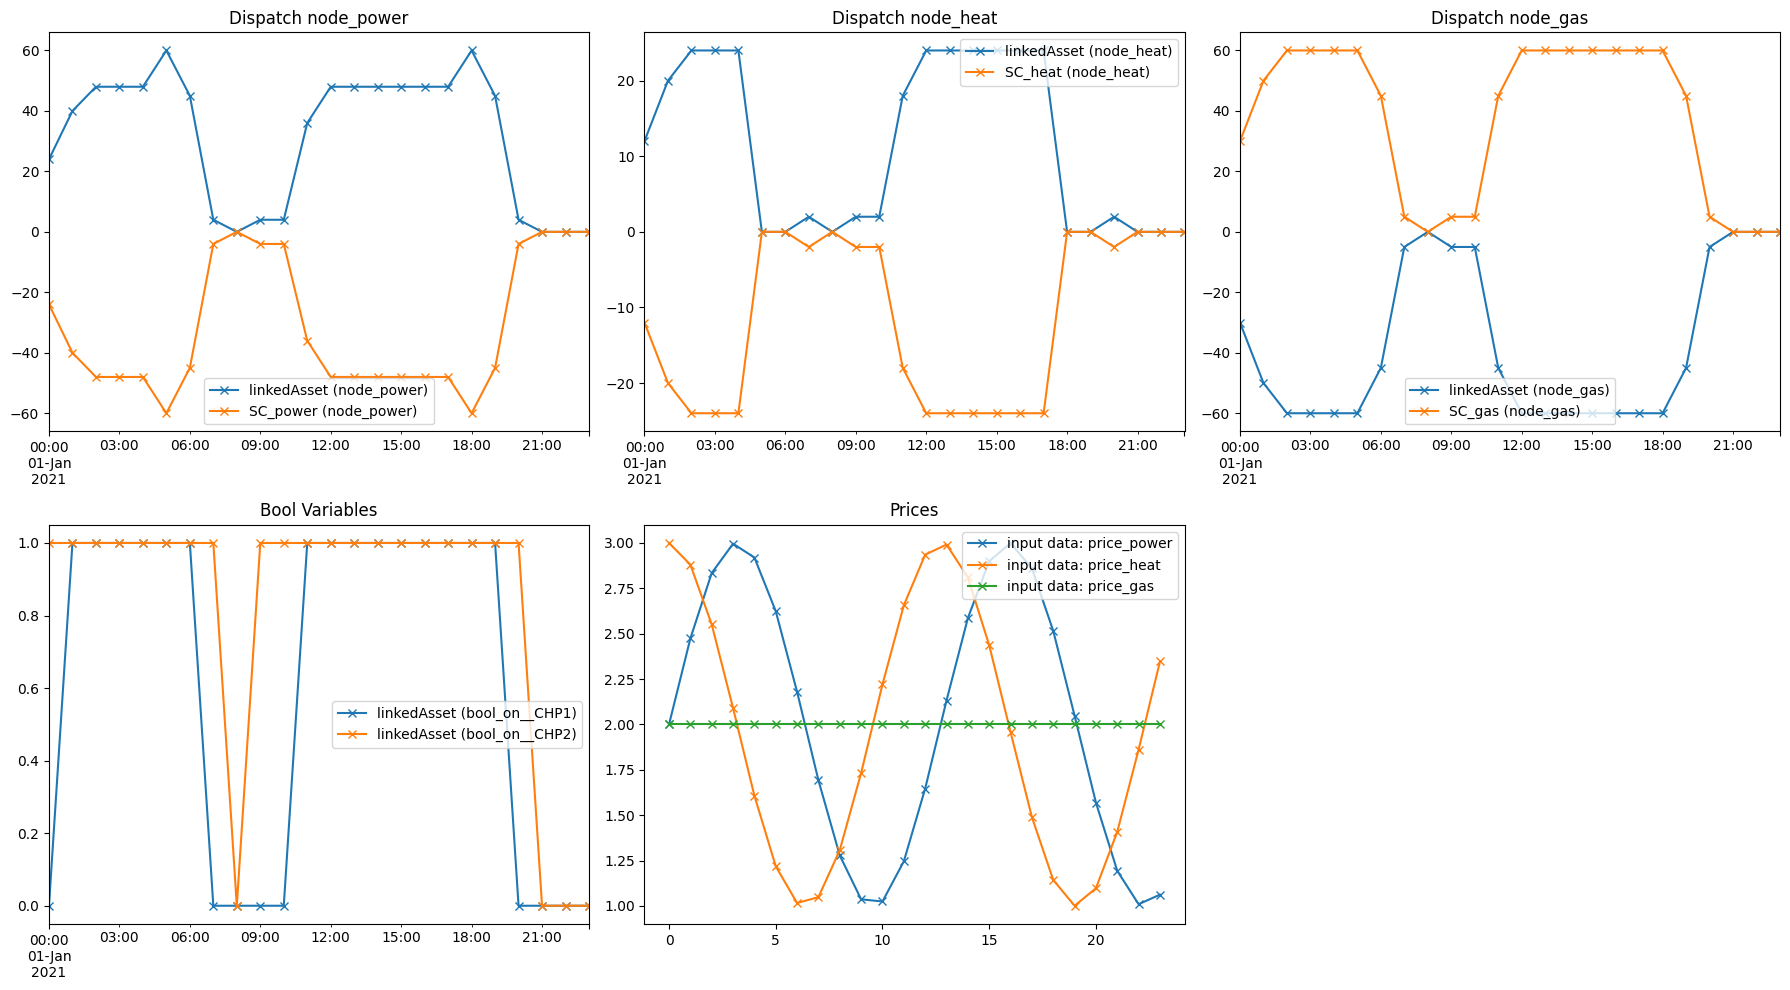

In [4]:
# Define the grid size to display the figures:
num_imgs_per_row = 3
num_nodes = len(portfolio.nodes)
num_imgs = num_nodes+2
num_img_rows=int(np.ceil(num_imgs/num_imgs_per_row))
fig, ax = plt.subplots(num_img_rows, num_imgs_per_row, tight_layout = True, figsize=(18,5*num_img_rows))
ax = ax.reshape(-1)

# Plot the dispatch for each node:
current_ax=0
dispatch_per_node = {node: [] for node in portfolio.nodes}
for mycol in out['dispatch'].columns.values:
    for node in dispatch_per_node:
        if '(' + node + ')' in mycol:
            dispatch_per_node[node].append(mycol)
for node in dispatch_per_node:
    out['dispatch'][dispatch_per_node[node]].plot(ax=ax[current_ax], style='-x')
    ax[current_ax].set_title("Dispatch " + node)
    current_ax+=1

# Plot internal variables:
for v in out['internal_variables']:
    out['internal_variables'][v].plot(ax=ax[current_ax], style='-x', label=v)
if out['internal_variables'].shape[1] == 0:
    ax[current_ax].text(0.4, 0.5, "No bool variables present")
ax[current_ax].set_title('Bool Variables')
ax[current_ax].legend()
current_ax+=1

# Plot prices
for key in out['prices']:
    out['prices'][key].plot(ax=ax[current_ax], style='-x', label=key)
ax[current_ax].set_title('Prices')
ax[current_ax].legend()

# Remove empty axes:
for i in range(current_ax+1, len(ax)):
    fig.delaxes(ax[i])